<a href="https://colab.research.google.com/github/odeya-shnaps/Transfer-Learning-with-VGG/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG Training**

VGG is a neural network model that uses convolutional neural network (CNN) layers and was designed for the ImageNet challenge, which it won in 2014.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Datasets**

**Colon**

> This dataset contains 25,000 histopathological images with 5 classes. All images are 768 x 768 pixels in size and are in jpeg file format.
The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 750 total images of lung tissue (250 benign lung tissue, 250 lung adenocarcinomas, and 250 lung squamous cell carcinomas) and 500 total images of colon tissue (250 benign colon tissue and 250 colon adenocarcinomas) and augmented to 25,000 using the Augmentor package.
There are five classes in the dataset, each with 5,000 images.
**We used only 2 classes for binary classification: Colon adenocarcinoma,
Colon benign tissue**.
 [view dataset](https://www.kaggle.com/andrewmvd/lung-and-colon-cancer-histopathological-images)

 We will use different approaches to maximize the accuracy on this dataset.

**Breast Cancer:**


> The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive).  [view dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)


We will use this dataset for transfer learning.

**Loading the datasets from drive**

In [ ]:
# mount the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip dataset
!rm -rf data1
!cp /content/drive/MyDrive/breast_cancer.zip .
!mkdir data1
!unzip -q breast_cancer.zip -d data1

In [ ]:
# unzip dataset
!rm -rf data2
!cp /content/drive/MyDrive/colon_dataset.zip .
!mkdir data2
!unzip -q colon_dataset.zip -d data2

# **Training Functions**

In [ ]:
# count the trainable parameters of the model
def count_parameters(model):
    num =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    return f'The model has {num:,} trainable parameters'

In [ ]:
# calculate batch accuracy
def calculate_accuracy(y_pred, y):
  correct = 0
  size = len(y_pred)
  for i in range(size):
    if y_pred[i] > 0.5:
      prediction = 1
    else:
      prediction = 0
    if prediction == y[i]:
      correct +=1
  return correct / size

In [ ]:
def train(model, iterator, optimizer, criterion, device, isTransfer=False):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        if isTransfer:
          y_pred, _ = model(x)
        else:
          y_pred = model(x)

        y = y.unsqueeze(1)
        loss = criterion(y_pred, y.float())

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device, isTransfer=False):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            if isTransfer:
              y_pred, _ = model(x)
            else:
              y_pred = model(x)

            y = y.unsqueeze(1)
            loss = criterion(y_pred, y.float())

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# **Training With Pre-Trained VGG**

There's a few things we need to consider in regards to data processing when using pre-trained models.
Even though the VGG models can handle images as small as 50x50 and convolutional layers are translation invariant, our images still need to be resized as the pre-trained classifier layer is expecting certain features to appear in certain places within the flattened 512x7x7 output of the features layer after the adaptive average pooling. Using a different image size than was used to pre-train the model causes features sent to the classifier to be in different places than expected, and thus leads to poor performance when using the pre-trained model.

**Data Processing**

As mentioned in the torchvision models, all pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Thus, we need to resize our 50x50 images to 224x224 and also normalize them with the  given means and stds.


In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

# Train uses data augmentation
train_transform = transforms.Compose([
                          transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                          transforms.RandomRotation(degrees=15),
                          transforms.ColorJitter(),
                          transforms.RandomHorizontalFlip(),
                          transforms.CenterCrop(pretrained_size), # Image net standards
                          transforms.ToTensor(),
                          transforms.Normalize(mean = pretrained_means, # Image net standards
                                                std = pretrained_stds)
                       ])

# test does not use augmentation
test_transforms = transforms.Compose([
                           transforms.Resize(size=256),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])


train_data = ImageFolder('data2/colon_dataset/train', transform = train_transform)

test_data = ImageFolder('data2/colon_dataset/test', transform = test_transforms)

print(train_data[0][0].size())
print(test_data[0][0].size())

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


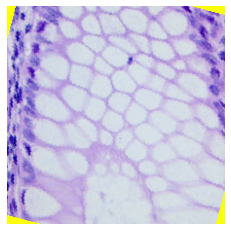

In [ ]:
to_img = transforms.ToPILImage()
#0.2 and 0.4 are approximations of the standard deviation and mean
a=to_img(train_data[0][0]*0.2+0.4)
plt.imshow(a)
plt.axis('off')
plt.show()

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 8100
Number of validation examples: 900
Number of testing examples: 1000


Every epoch, the training DataLoader will apply a slightly different random transformation to the images for training data augmentation.

In [ ]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

Loading pre-trained vgg-11 with batch normalization.

In [ ]:
pretrained_model = models.vgg11_bn(pretrained = True)

print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

All of torchvision's pre-trained models are trained as image classification models on the ImageNet dataset. A dataset of 224x224 color images with 1000 classes, therefore the final layer will have a 1000 dimensional output.
We can change the last layer specifically by indexing into the classifier layer of the pre-trained model.
Our dataset only has 2 classes, so we want to adjust the last layer to have 1  dimensional output for binary classification.

In [ ]:
OUTPUT_DIM = 1

IN_FEATURES = pretrained_model.classifier[-1].in_features

# changing last layer and adding more layers for gradualness transition.
final_fc = nn.Sequential(
    nn.Linear(IN_FEATURES, 10),
    nn.ReLU(),
    nn.Linear(10, OUTPUT_DIM),
    nn.Sigmoid())

pretrained_model.classifier[-1] = final_fc
# print out the classifier of our model to ensure the final linear layer now has the wanted output dimension.
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


Instead of training all of the parameters we have loaded from a pre-trained model, we could instead only learn some of them and leave some "frozen" at their pre-trained values. As our model will then have less trainable parameters it will usually train faster.
We aren't going to freeze any parameters in this notebook, because after trying it we got a lower accuracy.
If we wanted to freeze the features layer then we could do that with:


```
for parameter in model.features.parameters():
    parameter.requires_grad = False
```



In [ ]:
count_parameters(pretrained_model)

'The model has 128,812,821 trainable parameters'

In [ ]:
START_LR = 5e-4

optimizer = optim.Adam(pretrained_model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.BCELoss()

pretrained_model = pretrained_model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 6


best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(pretrained_model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(pretrained_model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(pretrained_model.state_dict(), 'pre-trained-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 4m 34s
	Train Loss: 0.076 | Train Acc: 98.01%
	 Val. Loss: 0.005 |  Val. Acc: 99.90%
Epoch: 02 | Epoch Time: 4m 35s
	Train Loss: 0.011 | Train Acc: 99.72%
	 Val. Loss: 0.001 |  Val. Acc: 100.00%
Epoch: 03 | Epoch Time: 4m 31s
	Train Loss: 0.057 | Train Acc: 99.67%
	 Val. Loss: 4.876 |  Val. Acc: 66.15%
Epoch: 04 | Epoch Time: 4m 30s
	Train Loss: 0.011 | Train Acc: 99.69%
	 Val. Loss: 0.001 |  Val. Acc: 100.00%
Epoch: 05 | Epoch Time: 4m 29s
	Train Loss: 0.013 | Train Acc: 99.67%
	 Val. Loss: 0.007 |  Val. Acc: 99.79%
Epoch: 06 | Epoch Time: 4m 28s
	Train Loss: 0.005 | Train Acc: 99.88%
	 Val. Loss: 0.002 |  Val. Acc: 99.90%


**Test Accuracy**

In [ ]:
pretrained_model.load_state_dict(torch.load('pre-trained-model.pt'))

test_loss, test_acc = evaluate(pretrained_model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.000 | Test Acc: 100.00%


# **Training With VGG**

Training colon dataset on vgg-11 with parameters that will be initialized randomly.

**Loading colon dataset**

The original size of the images is 768 x 768 pixels.
VGG has many layers and training such a large images is taking a lot of time and memory, so we changed the images to a smaller size while making sure the accuracy will stay high.

In [ ]:
img_size = 100

# Train uses data augmentation
train_transform = transforms.Compose([
                          transforms.Resize(img_size),
                          transforms.RandomRotation(degrees=15),
                          transforms.ColorJitter(),
                          transforms.RandomHorizontalFlip(),
                          transforms.CenterCrop(img_size),
                          transforms.ToTensor(),
                       ])

# test does not use augmentation
test_transforms = transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.CenterCrop(img_size),
                           transforms.ToTensor()
                       ])

train_data = ImageFolder('data2/colon_dataset/train', transform = train_transform)

test_data = ImageFolder('data2/colon_dataset/test', transform = test_transforms)

print(train_data[0][0].size())
print(test_data[0][0].size())

torch.Size([3, 100, 100])
torch.Size([3, 100, 100])


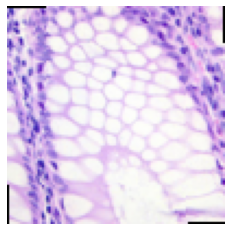

In [ ]:
to_img = transforms.ToPILImage()
a=to_img(train_data[0][0])
plt.imshow(a)
plt.axis('off')
plt.show()

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 8100
Number of validation examples: 900
Number of testing examples: 1000


In [ ]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                 batch_size = BATCH_SIZE)

Loading pre-trained vgg-11 with batch normalization. We dont want pre-trained.

In [ ]:
model = models.vgg11_bn()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Our dataset only has 2 classes, so we want to adjust the last layer to have 1 dimensional output for binary classification.

In [ ]:
OUTPUT_DIM = 1

IN_FEATURES = model.classifier[-1].in_features

# changing last layer and adding more layers for gradualness transition.
final_fc = nn.Sequential(
    nn.Linear(IN_FEATURES, 10),
    nn.ReLU(),
    nn.Linear(10, OUTPUT_DIM),
    nn.Sigmoid())

model.classifier[-1] = final_fc
# print out the classifier of our model to ensure the final linear layer now has the wanted output dimension.
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
count_parameters(model)

'The model has 128,812,821 trainable parameters'

In [ ]:
START_LR = 5e-4

optimizer = optim.Adam(model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 8


best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 1s
	Train Loss: 0.470 | Train Acc: 90.49%
	 Val. Loss: 0.351 |  Val. Acc: 95.62%
Epoch: 02 | Epoch Time: 2m 1s
	Train Loss: 0.302 | Train Acc: 98.30%
	 Val. Loss: 0.313 |  Val. Acc: 97.40%
Epoch: 03 | Epoch Time: 2m 1s
	Train Loss: 0.158 | Train Acc: 97.47%
	 Val. Loss: 0.137 |  Val. Acc: 93.75%
Epoch: 04 | Epoch Time: 2m 1s
	Train Loss: 0.038 | Train Acc: 98.65%
	 Val. Loss: 0.106 |  Val. Acc: 95.00%
Epoch: 05 | Epoch Time: 2m 0s
	Train Loss: 0.016 | Train Acc: 99.40%
	 Val. Loss: 0.590 |  Val. Acc: 86.04%
Epoch: 06 | Epoch Time: 2m 1s
	Train Loss: 0.016 | Train Acc: 99.27%
	 Val. Loss: 0.041 |  Val. Acc: 99.17%
Epoch: 07 | Epoch Time: 2m 1s
	Train Loss: 0.015 | Train Acc: 99.46%
	 Val. Loss: 0.016 |  Val. Acc: 99.17%
Epoch: 08 | Epoch Time: 2m 0s
	Train Loss: 0.011 | Train Acc: 99.67%
	 Val. Loss: 0.045 |  Val. Acc: 97.81%


**Test Accuracy**

In [ ]:
model.load_state_dict(torch.load('model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.020 | Test Acc: 98.96%


# **Transfer Learning**

Training data is a valuable resource, and sometimes there is not enough of it for training a neural netowrk at scale. To handle this situation, one approach is transfer learning, where we train our network on a different related task, and then switch to train it on the downstream task that we focus on. In this part we will pre-train vgg-11 on breast cancer dataset and then train it on colon dataset.

We could adjust the last layer to have 1 dimensional output like we already did, however it only returns the final output layer and not the intermediate representation as we want. Therefore it will be easier to build new model with all vgg-11 layers inside.

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 32),
        )
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 10)
        self.fc3 = nn.Linear(10, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        h = F.relu(self.classifier(x))
        x = F.relu(self.fc1(h))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x, h

New Module VGG2, which uses VGG as one of its sub modules, followed by some additional layers.

In [ ]:
class VGG2(nn.Module):
    def __init__(self, trained_vgg, output_dim):
        super().__init__()

        self.trained_vgg = trained_vgg
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 10)
        self.fc3 = nn.Linear(10, output_dim)

    def forward(self, x):
        _, x = self.trained_vgg.forward(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

Next up is calculating the features for VGG-11 configuration.

Typically the VGG configurations are defined as lists. Each item in the list is either 'M', which denotes a max pooling layer, or an integer, which denotes a convolutional layer with that many filters.

In [ ]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

get_vgg_layers iterates over the configuration list and appends each layer to layers, then it converts them to a nn.Sequential as it returns.

In [ ]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c

    return nn.Sequential(*layers)

**Load transfer dataset - breast cancer**

The images in both datasets need to have the same size.

In [ ]:
img_size = 100

# Train uses data augmentation
train_transform = transforms.Compose([
                          transforms.Resize(img_size),
                          transforms.RandomRotation(degrees=15),
                          transforms.ColorJitter(),
                          transforms.RandomHorizontalFlip(),
                          transforms.CenterCrop(img_size),
                          transforms.ToTensor(),
                       ])

# valid  does not use augmentation
valid_transforms = transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.CenterCrop(img_size),
                           transforms.ToTensor()
                       ])

train_transfer_data = ImageFolder('data1/breast_cancer/', transform = train_transform)

# don't need test beacuse we measure the accuracy of the main dataset - colon.

print(train_transfer_data[0][0].size())

torch.Size([3, 100, 100])


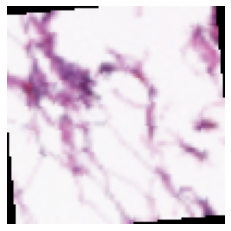

In [ ]:
to_img = transforms.ToPILImage()
a=to_img(train_transfer_data[50][0])
plt.imshow(a)
plt.axis('off')
plt.show()

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_transfer_data) * VALID_RATIO)
n_valid_examples = len(train_transfer_data) - n_train_examples

train_transfer_data, valid_transfer_data = data.random_split(train_transfer_data,
                                           [n_train_examples, n_valid_examples])

valid_transfer_data = copy.deepcopy(valid_transfer_data)
valid_transfer_data.dataset.transform = valid_transforms

print(f'Number of training examples: {len(train_transfer_data)}')
print(f'Number of validation examples: {len(valid_transfer_data)}')

Number of training examples: 249771
Number of validation examples: 27753


In [ ]:
BATCH_SIZE = 64

train_transfer_iterator = data.DataLoader(train_transfer_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_transfer_iterator = data.DataLoader(valid_transfer_data,
                                 batch_size = BATCH_SIZE)

In [ ]:
# get layers of vgg-11
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

Create new instance of VGG. We can see that it has the same layers as vgg-11 except from the last layers.

In [ ]:
OUTPUT_DIM = 1

transfer_model = VGG(vgg11_layers, OUTPUT_DIM)

print(transfer_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
FOUND_LR = 5e-4

params = [
          {'params': transfer_model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': transfer_model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.BCELoss()

transfer_model = transfer_model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 8

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(transfer_model, train_transfer_iterator, optimizer, criterion, device, True)
    valid_loss, valid_acc = evaluate(transfer_model, valid_transfer_iterator, criterion, device, True)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(transfer_model.state_dict(), 'transfer-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 19m 33s
	Train Loss: 0.332 | Train Acc: 86.04%
	 Val. Loss: 0.292 |  Val. Acc: 87.72%
Epoch: 02 | Epoch Time: 19m 37s
	Train Loss: 0.296 | Train Acc: 87.80%
	 Val. Loss: 0.279 |  Val. Acc: 88.30%
Epoch: 03 | Epoch Time: 19m 36s
	Train Loss: 0.282 | Train Acc: 88.29%
	 Val. Loss: 0.305 |  Val. Acc: 87.74%
Epoch: 04 | Epoch Time: 19m 36s
	Train Loss: 0.270 | Train Acc: 88.74%
	 Val. Loss: 0.324 |  Val. Acc: 89.24%
Epoch: 05 | Epoch Time: 19m 37s
	Train Loss: 0.262 | Train Acc: 89.15%
	 Val. Loss: 0.272 |  Val. Acc: 89.26%
Epoch: 06 | Epoch Time: 19m 35s
	Train Loss: 0.255 | Train Acc: 89.39%
	 Val. Loss: 0.277 |  Val. Acc: 89.92%
Epoch: 07 | Epoch Time: 19m 36s
	Train Loss: 0.250 | Train Acc: 89.71%
	 Val. Loss: 0.268 |  Val. Acc: 90.13%
Epoch: 08 | Epoch Time: 19m 35s
	Train Loss: 0.246 | Train Acc: 89.88%
	 Val. Loss: 0.280 |  Val. Acc: 90.10%


**Load main dataset - colon**

In [ ]:
img_size = 100

# Train uses data augmentation
train_transform = transforms.Compose([
                          transforms.Resize(img_size),
                          transforms.RandomRotation(degrees=15),
                          transforms.ColorJitter(),
                          transforms.RandomHorizontalFlip(),
                          transforms.CenterCrop(img_size),
                          transforms.ToTensor(),
                       ])

# test does not use augmentation
test_transforms = transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.CenterCrop(img_size),
                           transforms.ToTensor()
                       ])

train_data = ImageFolder('data2/colon_dataset/train', transform = train_transform)

test_data = ImageFolder('data2/colon_dataset/test', transform = test_transforms)

print(train_data[0][0].size())
print(test_data[0][0].size())

torch.Size([3, 100, 100])
torch.Size([3, 100, 100])


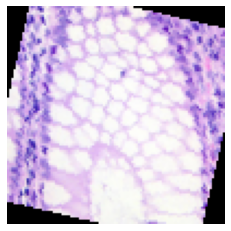

In [ ]:
to_img = transforms.ToPILImage()
a=to_img(train_data[0][0])
plt.imshow(a)
plt.axis('off')
plt.show()

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 8100
Number of validation examples: 900
Number of testing examples: 1000


In [ ]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                 batch_size = BATCH_SIZE)


Create VGG2, which uses trained VGG as one of its sub modules

In [ ]:
OUTPUT_DIM = 1
transfer_model.load_state_dict(torch.load('transfer-model.pt'))
final_model = VGG2(transfer_model, OUTPUT_DIM)

In [ ]:
START_LR = 5e-4

optimizer = optim.Adam(final_model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.BCELoss()

final_model = final_model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 8

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(final_model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(final_model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(final_model.state_dict(), 'final-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 15s
	Train Loss: 0.162 | Train Acc: 94.58%
	 Val. Loss: 0.047 |  Val. Acc: 98.12%
Epoch: 02 | Epoch Time: 2m 14s
	Train Loss: 0.061 | Train Acc: 98.03%
	 Val. Loss: 0.024 |  Val. Acc: 98.75%
Epoch: 03 | Epoch Time: 2m 13s
	Train Loss: 0.036 | Train Acc: 98.86%
	 Val. Loss: 0.037 |  Val. Acc: 98.54%
Epoch: 04 | Epoch Time: 2m 14s
	Train Loss: 0.028 | Train Acc: 99.15%
	 Val. Loss: 0.003 |  Val. Acc: 99.90%
Epoch: 05 | Epoch Time: 2m 13s
	Train Loss: 0.018 | Train Acc: 99.50%
	 Val. Loss: 0.028 |  Val. Acc: 99.27%
Epoch: 06 | Epoch Time: 2m 13s
	Train Loss: 0.019 | Train Acc: 99.46%
	 Val. Loss: 0.607 |  Val. Acc: 89.79%
Epoch: 07 | Epoch Time: 2m 13s
	Train Loss: 0.016 | Train Acc: 99.41%
	 Val. Loss: 0.166 |  Val. Acc: 94.69%
Epoch: 08 | Epoch Time: 2m 13s
	Train Loss: 0.036 | Train Acc: 98.95%
	 Val. Loss: 0.039 |  Val. Acc: 98.02%


**Test Accuracy**

In [ ]:
final_model.load_state_dict(torch.load('final-model.pt'))

test_loss, test_acc = evaluate(final_model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.002 | Test Acc: 99.90%


# **Conclusions**

After all our tests we conclude that the best way to train our dataset is using
the pre-trained VGG model. Although the results were very similar in all approaches, it seems that the most useful characteristic was the richness of the
ImageNet dataset, with the large amount of images that it provided.
